## Predicting CrossFit Games Ranking based on Benchmark Workout Performance

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import sklearn
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# import warnings
# warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Principal Component Analysis

In [9]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/data_men_women.xlsx')
df = df[~df['Rank_Worldwide'].isna()]

In [10]:
# Define the target values
y = df.loc[:, "Rank_Worldwide"].values

In [11]:
features = ['Back Squat (lbs)', 'Clean and Jerk (lbs)', 'Deadlift (lbs)',
       'Snatch (lbs)', 'Fight Gone Bad', 'Max Pull-ups', 'Chad1000x (s)',
       'L1 Benchmark (s)', 'Filthy 50 (s)', 'Fran (s)', 'Grace (s)',
       'Helen (s)', 'Run 5k (s)', 'Sprint 400m (s)']

# Multiple column features matrix
X = df.loc[:, features].values

df.loc[:, features]

,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
0,407.8547,319.6699,436.51476,266.75902,NaN,NaN,NaN,NaN,NaN,NaN,120.0,NaN,1329.0,NaN
1,429.9009,341.7161,462.97020,257.94054,420.0,36.0,NaN,NaN,NaN,126.0,100.0,437.0,1158.0,57.0
2,385.8085,330.6930,485.01640,264.55440,383.0,53.0,NaN,NaN,NaN,152.0,113.0,NaN,NaN,NaN
3,375.0000,285.0000,475.00000,245.00000,400.0,71.0,NaN,NaN,1421.0,147.0,144.0,NaN,1238.0,NaN
4,480.0000,345.0000,475.00000,275.00000,NaN,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8408,297.6237,231.4851,385.80850,180.77884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8409,275.5775,231.4851,363.76230,187.39270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8410,330.6930,264.5544,374.78540,200.62042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8411,330.6930,242.5082,440.92400,182.98346,321.0,NaN,NaN,NaN,NaN,200.0,106.0,540.0,1320.0,70.0


In [12]:
# Impute missing values with the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imp.fit_transform(X)
X_imputed

array([[ 407.8547    ,  319.6699    ,  436.51476   , ...,  578.99081036,
        1329.        ,   72.29166667],
       [ 429.9009    ,  341.7161    ,  462.9702    , ...,  437.        ,
        1158.        ,   57.        ],
       [ 385.8085    ,  330.693     ,  485.0164    , ...,  578.99081036,
        1388.89738431,   72.29166667],
       ...,
       [ 330.693     ,  264.5544    ,  374.7854    , ...,  578.99081036,
        1388.89738431,   72.29166667],
       [ 330.693     ,  242.5082    ,  440.924     , ...,  540.        ,
        1320.        ,   70.        ],
       [ 200.        ,  165.        ,  320.        , ...,  578.99081036,
        1388.89738431,   72.29166667]])

In [13]:
# Standardize the data
X_scaled = StandardScaler().fit_transform(X_imputed)
X_scaled

array([[ 9.37650435e-01,  1.21763012e+00,  4.33495668e-01, ...,
         0.00000000e+00, -4.05848001e-01,  1.45326357e-15],
       [ 1.20390957e+00,  1.57891277e+00,  7.16070022e-01, ...,
        -1.90443701e+00, -1.56449639e+00, -1.56379208e+00],
       [ 6.71391300e-01,  1.39827144e+00,  9.51548651e-01, ...,
         0.00000000e+00, -1.54062072e-15,  1.45326357e-15],
       ...,
       [ 5.74346338e-03,  3.14423495e-01, -2.25844493e-01, ...,
         0.00000000e+00, -1.54062072e-15,  1.45326357e-15],
       [ 5.74346338e-03, -4.68591538e-02,  4.80591393e-01, ...,
        -5.22960198e-01, -4.66829495e-01, -2.34355761e-01],
       [-1.57267845e+00, -1.31702670e+00, -8.11015219e-01, ...,
         0.00000000e+00, -1.54062072e-15,  1.45326357e-15]])

In [14]:
# Apply PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

In [15]:
# Create a dataframe with the principal components and target variable
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df['target'] = y
pca_df

,PC1,PC2,target
0,-1.929175,0.699331,357.0
1,-3.954949,-1.910831,732.0
2,-2.759544,0.093715,1022.0
3,-2.629518,-0.581739,1713.0
4,-2.764778,1.212270,1794.0
...,...,...,...
8378,0.397501,-0.240306,11.0
8379,0.548880,-0.343182,33.0
8380,-0.117511,0.057135,4.0
8381,-0.495567,-0.500803,7387.0


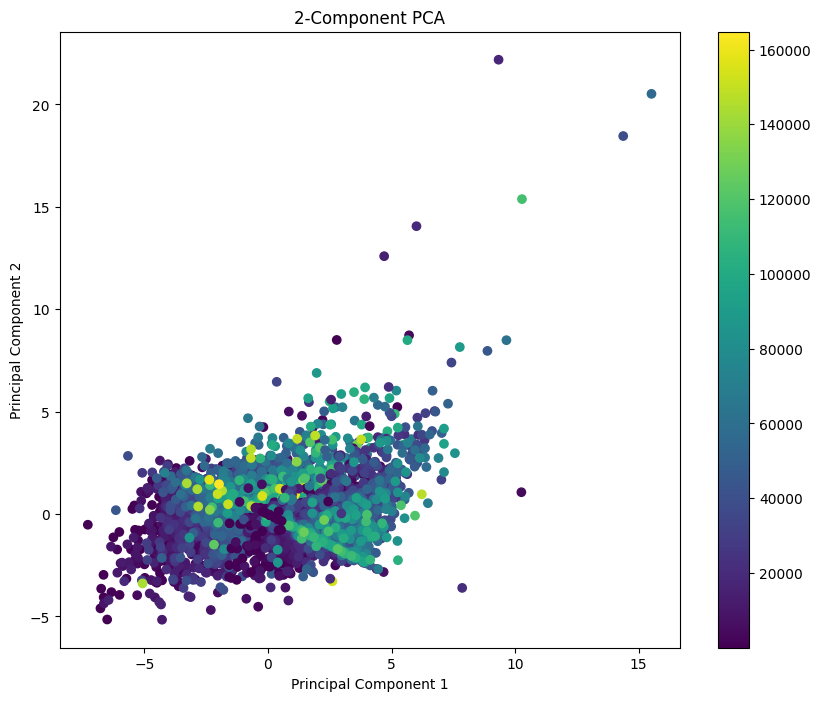

In [16]:
# Visualize the 2D projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x='PC1', y='PC2', c='target', cmap='viridis', data=pca_df)
plt.colorbar(scatter)
plt.title('2-Component PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [17]:
pca.explained_variance_ratio_

array([0.32079044, 0.11635922])

In [18]:
sum(pca.explained_variance_ratio_)

0.4371496548523344

In [19]:
# Tune n_components
# determine the maximum number of components,
# determined by the minimum of the number of samples or features
max_components = min(X.shape[0], X.shape[1])
max_components

14

In [20]:
# find the n_component value that yields the highest sum of explained_variance_ratio_
explained_variance_ratios = []
for n_components in range(1, max_components + 1):
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    explained_variance_ratios.append(np.sum(pca.explained_variance_ratio_))

optimal_n_components = np.argmax(explained_variance_ratios) + 1
print(f"Optimal n_component: {optimal_n_components}")
print(f"Sum of explained_variance_ratio_: {explained_variance_ratios[optimal_n_components - 1]}")

Optimal n_component: 14
Sum of explained_variance_ratio_: 0.9999999999999998


In [21]:
# find the n_component value such that the sum of explained_variance_ratio_ is >=95%
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95_percent = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"n_component: {n_components_95_percent}")
print(f"Sum of explained_variance_ratio_: {explained_variance_ratios[n_components_95_percent - 1]}")

n_component: 11
Sum of explained_variance_ratio_: 0.9711522222380122


In [22]:
# apply PCA with n_components_95_percent
pca = PCA(n_components=n_components_95_percent)
principalComponents = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principalComponents,
                      columns=[f'PC{i+1}' for i in range(n_components_95_percent)])
pca_df['target'] = y
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,target
0,-1.929175,0.699332,-0.169700,-0.154950,-0.116228,-0.252784,-0.084762,0.162789,-0.104401,0.565793,0.282066,357.0
1,-3.954949,-1.910831,-0.368825,-0.472220,-0.187996,-0.753300,0.658870,0.455293,1.773260,-0.311479,-0.108043,732.0
2,-2.759544,0.093713,-0.033165,0.321799,0.198553,0.617617,-0.688612,-0.211627,0.983405,0.194026,-0.027894,1022.0
3,-2.629518,-0.581738,1.242938,0.831641,0.810464,0.952040,-0.082705,-0.491222,1.390992,0.124543,0.176187,1713.0
4,-2.764777,1.212273,-0.438780,-0.036375,-0.223932,0.135896,0.091312,-0.191289,-0.237186,-0.049541,-0.664311,1794.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8378,0.397501,-0.240307,0.054290,0.009402,0.034045,-0.002363,-0.014713,-0.074240,0.031081,0.008758,-0.002647,11.0
8379,0.548880,-0.343183,0.087436,0.016963,0.053232,0.004484,-0.032373,-0.122997,0.043334,0.014737,-0.007414,33.0
8380,-0.117511,0.057134,-0.005027,0.000363,-0.004569,0.008110,-0.009341,-0.001011,-0.008587,0.001007,-0.006521,4.0
8381,-0.495567,-0.500804,-0.116625,-0.379606,-0.115972,-0.630035,-0.061760,-0.457776,-0.394467,0.408456,0.380186,7387.0


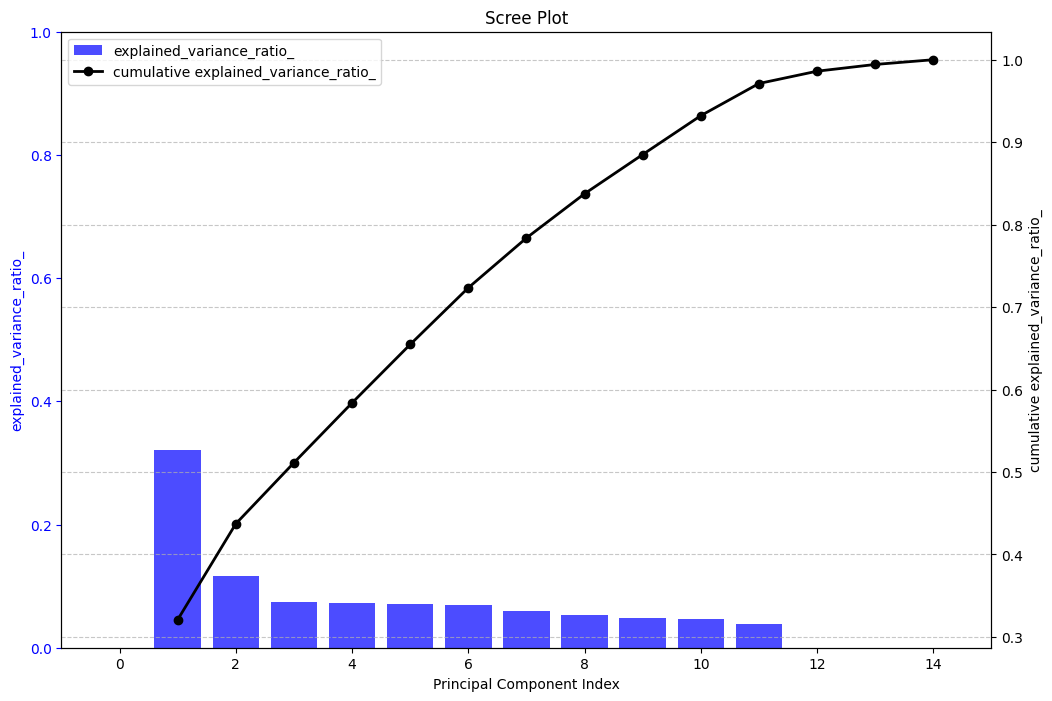

In [23]:
# scree plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))
explained_variances = pca.explained_variance_ratio_

# bar chart for explained variance ratio
ax1.bar(range(1, len(explained_variances) + 1),
        explained_variances, color='blue', alpha=0.7, label='explained_variance_ratio_')
ax1.set_xlabel('Principal Component Index')
ax1.set_ylabel('explained_variance_ratio_', color='blue')
ax1.tick_params('y', colors='blue')

# line chart for cumulative explained variance
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_explained_variance) + 1),
         cumulative_explained_variance, color='black',
         marker='o', linestyle='-', linewidth=2,
         label='cumulative explained_variance_ratio_')
ax2.set_ylabel('cumulative explained_variance_ratio_', color='black')
ax2.tick_params('y', colors='black')

ax1.set_xlim(-1, 15)
ax2.set_xlim(-1, 15)
ax1.set_ylim(0, 1)


# legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Scree Plot')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [24]:
pca.components_

array([[-4.15876133e-01, -4.28600744e-01, -4.05289913e-01,
        -4.20545859e-01, -2.08429692e-01, -1.78798208e-01,
         1.42228779e-02,  1.57450525e-02,  1.41190034e-01,
         2.71464473e-01,  2.07272786e-01,  1.82411358e-01,
         1.78206035e-01,  1.57311443e-01],
       [ 2.66263609e-01,  2.39732137e-01,  2.66903362e-01,
         2.36946693e-01, -3.49855997e-01,  5.45006972e-03,
         5.91988086e-02,  5.24858743e-02,  4.12272935e-01,
         2.63331659e-01,  3.07665173e-01,  3.98644217e-01,
         2.09775220e-01,  2.80481043e-01],
       [-8.16256455e-02, -4.59211233e-02, -6.12652119e-02,
        -2.31421308e-02, -6.92350383e-02,  6.03246515e-01,
        -3.63634119e-01, -2.19634778e-01,  3.65776442e-02,
         1.21663919e-01,  2.06825991e-01,  3.16667813e-01,
        -4.25408231e-01, -3.12414426e-01],
       [-1.37675735e-02, -1.05860789e-02, -1.61182096e-02,
         7.65240543e-04,  1.74532579e-01,  2.28750774e-01,
        -1.98489521e-01,  8.09578307e-01, -3.

In [25]:
pc_df = pd.DataFrame(data=pca.components_,
                     columns=features)
pc_df

,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
0,-0.415876,-0.428601,-0.405290,-0.420546,-0.208430,-0.178798,0.014223,0.015745,0.141190,0.271464,0.207273,0.182411,0.178206,0.157311
1,0.266264,0.239732,0.266903,0.236947,-0.349856,0.005450,0.059199,0.052486,0.412273,0.263332,0.307665,0.398644,0.209775,0.280481
2,-0.081626,-0.045921,-0.061265,-0.023142,-0.069235,0.603247,-0.363634,-0.219635,0.036578,0.121664,0.206826,0.316668,-0.425408,-0.312414
3,-0.013768,-0.010586,-0.016118,0.000765,0.174533,0.228751,-0.198490,0.809578,-0.334650,-0.017475,0.158239,0.146637,0.022455,0.249984
4,-0.045966,-0.032023,-0.040338,-0.019576,0.059643,0.324840,0.900732,0.057547,-0.115044,0.021539,0.039895,0.190439,-0.100989,-0.096887
5,-0.000021,0.002316,-0.019191,0.017825,0.307103,0.237211,-0.047774,-0.524153,-0.348041,-0.114604,0.214022,0.073886,0.293472,0.547770
6,0.021851,0.006428,0.048732,-0.002818,-0.041045,-0.257339,0.102272,-0.020038,-0.030615,-0.004559,0.545549,-0.340502,-0.649488,0.286306
7,0.099617,0.056528,0.118073,0.042757,0.319380,-0.385298,-0.015400,-0.084166,-0.410159,0.609051,0.144168,0.219597,0.023702,-0.323403
8,-0.041738,-0.025689,-0.021225,-0.029618,0.770087,0.001922,0.004316,0.062266,0.620556,0.051300,0.014594,0.051915,-0.072428,0.058829
9,-0.014842,-0.001899,-0.011682,-0.005550,-0.026327,-0.220650,-0.015645,-0.060866,-0.082673,0.000620,-0.563334,0.495199,-0.465172,0.400614


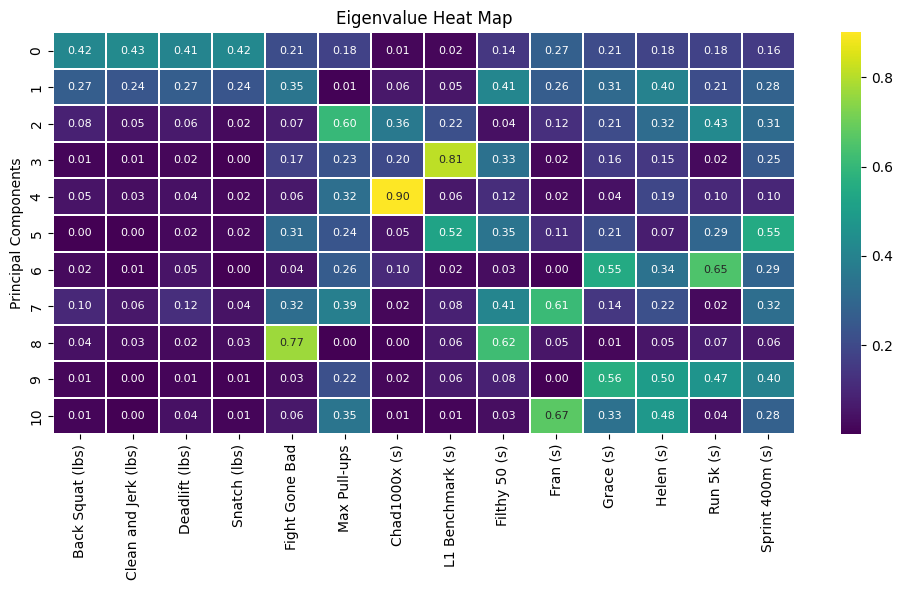

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(pc_df.abs(),
            cmap='viridis', annot=True, fmt='.2f', cbar=True, linewidths=0.2,
            annot_kws={"size": 8})#, cbar_kws={"shrink": 0.8})
plt.title('Eigenvalue Heat Map')
plt.ylabel('Principal Components')
plt.tight_layout()
# plt.savefig('eigenvalue.png', bbox_inches='tight')
plt.show()